# YouTube Trending Videos Analysis

## Group 4 - Members
* Shyam Akhil Nekkanti - 8982123
* Jun He (Helena) - 8903073
* Zheming Li (Brendan) - 8914152

## Summary

We are analyzing factors influencing YouTube video trending patterns in the US for 2018. 

In this presentation, we explore how YouTube videos perform over time by examining two key metrics: total views and trending duration. Our goal is to understand different patterns in video popularity and longevity, and to identify what sets the most successful videos apart.

To do this, we apply KMeans clustering to group videos with similar trends. Clustering helps us reveal hidden patterns by grouping videos based on their performance metrics, showing us if certain types of content consistently trend longer or attract more views.

## Step 1: Loading and Preparing Data

In this first step, we load the data and prepare it for analysis. We also calculate two new metrics:
- **trending duration** which counts the unique days a video remains trending. This feature will help us see how long each video stays popular.
- **total views** which sums the views for each video. 


In [161]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


def load_and_prepare_data(file_path):
  # Load dataset
  data = pd.read_csv(file_path)

  # Convert 'trending_date' to datetime format to allow date-based calculations
  data['trending_date'] = pd.to_datetime(data['trending_date'], format='%y.%d.%m')

  # Calculate trending duration as the count of unique trending dates for each video_id
  trending_duration = data.groupby('video_id')['trending_date'].nunique().reset_index()
  trending_duration.columns = ['video_id', 'trending_duration']

  # Merge the trending duration back into the main dataset
  data = pd.merge(data, trending_duration, on='video_id', how='left')

  # Sum views for each video_id to get total views
  total_views = data.groupby('video_id')['views'].sum().reset_index()
  total_views.columns = ['video_id', 'total_views']

  # Merge the total views back into the main dataset
  data = pd.merge(data, total_views, on='video_id', how='left')

  # Remove duplicated video_id entries
  data = data.drop_duplicates(subset='video_id')

  return data


df = load_and_prepare_data('./youtube-dataset/USvideos.csv')

df.head(10)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,trending_duration,total_views
0,2kyS6SvSYSE,2017-11-14,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/shantellmartin\nCANDICE - https://www.lovebilly.com\n\nfilmed this video in 4k on this -- http://amzn.to/2sTDnRZ\nwith this lens -- http://amzn.to/2rUJOmD\nbig drone - http://tinyurl.com/h4ft3oy\nOTHER GEAR --- http://amzn.to/2o3GLX5\nSony CAMERA http://amzn.to/2nOBmnv\nOLD CAMERA; http://amzn.to/2o2cQBT\nMAIN LENS; http://amzn.to/2od5gBJ\nBIG SONY CAMERA; http://amzn.to/2nrdJRO\nBIG Canon CAMERA; http://tinyurl.com/jn4q4vz\nBENDY TRIPOD THING; http://tinyurl.com/gw3ylz2\nYOU NEED THIS FOR THE BENDY TRIPOD; http://tinyurl.com/j8mzzua\nWIDE LENS; http://tinyurl.com/jkfcm8t\nMORE EXPENSIVE WIDE LENS; http://tinyurl.com/zrdgtou\nSMALL CAMERA; http://tinyurl.com/hrrzhor\nMICROPHONE; http://tinyurl.com/zefm4jy\nOTHER MICROPHONE; http://tinyurl.com/jxgpj86\nOLD DRONE (cheaper but still great);http://tinyurl.com/zcfmnmd\n\nfollow me; on http://instagram.com/caseyneistat\non https://www.facebook.com/cneistat\non https://twitter.com/CaseyNeistat\n\namazing intro song by https://soundcloud.com/discoteeth\n\nad disclosure. THIS IS NOT AN AD. not selling or promoting anything. but samsung did produce the Shantell Video as a 'GALAXY PROJECT' which is an initiative that enables creators like Shantell and me to make projects we might otherwise not have the opportunity to make. hope that's clear. if not ask in the comments and i'll answer any specifics.,7,15220962
1,1ZAPwfrtAFY,2017-11-14,The Trump Presidency: Last Week Tonight with John Oliver (HBO),LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week tonight donald trump""|""john oliver trump""|""donald trump""",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John Oliver discusses what we've learned so far and enlists our catheter cowboy to teach Donald Trump what he hasn't.\n\nConnect with Last Week Tonight online...\n\nSubscribe to the Last Week Tonight YouTube channel for more almost news as it almost happens: www.youtube.com/user/LastWeekTonight\n\nFind Last Week Tonight on Facebook like your mom would: http://Facebook.com/LastWeekTonight\n\nFollow us on Twitter for news about jokes and jokes about news: http://Twitter.com/LastWeekTonight\n\nVisit our official site for all that other stuff at once: http://www.hbo.com/lastweektonight",7,35193405
2,5qpjK5DgCt4,2017-11-14,"Racist Superman | Rudy Mancuso, King Bach & Lele Pons",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""|""racist""|""superman""|""love""|""rudy mancuso poo bear black white official music video""|""iphone x by pineapple""|""lelepons""|""hannahstocking""|""rudymancuso""|""inanna""|""anwar""|""sarkis""|""shots""|""shotsstudios""|""alesso""|""anitta""|""brazil""|""Getting My Driver's License | Lele Pons""",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► https://www.youtube.com/channel/UC5jkXpfnBhlDjqh0ir5FsIQ?sub_confirmation=1\n\nTHANKS FOR WATCHING! LIKE & SUBSCRIBE FOR MORE VIDEOS!\n-----------------------------------------------------------\nFIND ME ON: \nInstagram | http://instagram.com/rudymancuso\nTwitter | http://twitter.com/rudymancuso\nFacebook | http://facebook.com/rudymancuso\n\nCAST: \nRudy Mancuso | http://youtube.com/c/rudymancuso\nLele Pons | http://youtube.com/c/lelepons\nKing Bach | https://youtube.com/user/BachelorsPadTv\n\nVideo Effects: \nCaleb Natale | https://instagram.com/calebnatale

## Step 2: Selecting and Standardizing Features

For clustering, we select two features: "trending duration" and "views." 

1. **Trending duration**: This shows how long each video stayed trending. We’re curious if some videos stay trending longer than others and if that’s related to their popularity.
   
2. **Views**: The number of times the video was watched, indicating its popularity.

Before clustering, we need to standardize these features to ensure both are on a similar scale, which helps improve the clustering performance. Standardizing means transforming the data so that each feature has a mean of 0 and a standard deviation of 1. 

In [153]:
def standardize_features(data):
  # Select relevant features for clustering: trending duration and views
  features = data[['trending_duration', 'total_views']].dropna()

  # Standardize features to have mean=0 and variance=1, improving clustering performance
  scaler = StandardScaler()
  scaled_features = scaler.fit_transform(features)
  return scaled_features, features


scaled_features, features = standardize_features(df)

## Step 3: Finding the Optimal Number of Clusters (k)

To decide on the best number of clusters (k) for our data, we use something called the **Elbow Method**. 

Here's how it works:
- We run the KMeans algorithm with different values of k (from 1 to 10).
- For each k, we measure something called **inertia**. Inertia tells us how "tight" our clusters are; lower inertia means the points in each cluster are closer to each other.
  
As k increases, inertia naturally decreases. But, after a certain point, adding more clusters doesn’t improve much. The **elbow point** on the graph is where inertia starts to level off, showing that more clusters don't add much value.


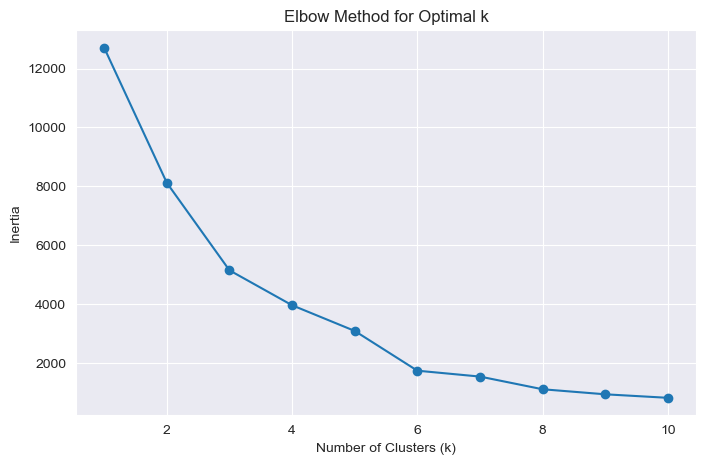

In [154]:
def find_optimal_k(scaled_features, max_k=10):
  # Calculate inertia for each value of k in the range to find optimal k using the Elbow Method
  inertia = []
  for k in range(1, max_k + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

  # Plot the elbow curve to visualize the optimal k
  plt.figure(figsize=(8, 5))
  plt.plot(range(1, max_k + 1), inertia, marker='o')
  plt.xlabel('Number of Clusters (k)')
  plt.ylabel('Inertia')
  plt.title('Elbow Method for Optimal k')
  plt.show()


# Use the elbow method to determine the optimal number of clusters
find_optimal_k(scaled_features, max_k=10)

## Step 4: KMeans Clustering

**KMeans** is a type of clustering algorithm. Clustering is a way to group similar items together based on their features. Here’s how KMeans works:

1. We set a number of clusters, k.
2. The algorithm picks k points randomly as the starting centers of each cluster.
3. Each data point is assigned to the nearest cluster center.
4. The algorithm then recalculates the center of each cluster based on the points in that cluster.
5. Steps 3 and 4 repeat until the clusters no longer change.

Based on the elbow method, we decided on 6 clusters. Now, we run KMeans with k=6 and visualize the results.


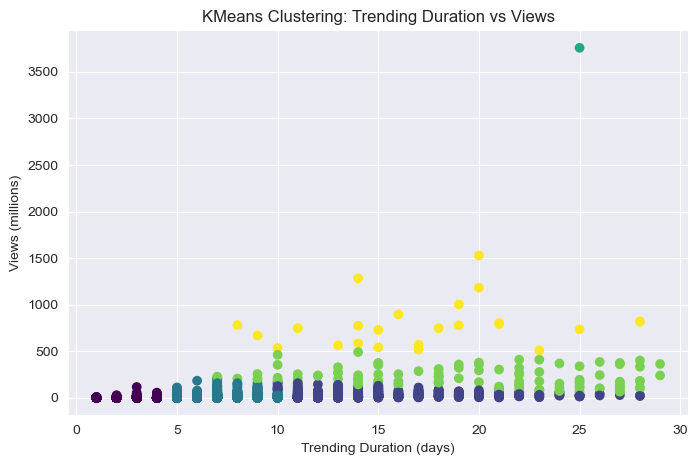

In [157]:
def apply_kmeans(scaled_features, features, n_clusters=3):
  # Apply KMeans clustering with a specified number of clusters (n_clusters)
  kmeans = KMeans(n_clusters=n_clusters, random_state=42)
  kmeans.fit(scaled_features)

  # Add cluster labels to the original feature set for visualization
  features['cluster'] = kmeans.labels_

  # Plot the clustering result showing how views and trending duration are grouped
  plt.figure(figsize=(8, 5))
  plt.scatter(features['trending_duration'], features['total_views'] / 1_000_000, c=features['cluster'], cmap='viridis',
              marker='o')
  plt.xlabel('Trending Duration (days)')
  plt.ylabel('Views (millions)')
  plt.title('KMeans Clustering: Trending Duration vs Views')
  plt.show()


apply_kmeans(scaled_features, features, n_clusters=6)

The clustering result with total views and trending duration at `k=6` shows some differentiation, but most clusters still overlap at lower view counts and shorter trending durations.

One cluster includes a significant outlier with very high views (over 3 billion). This cluster likely represents a rare, highly popular video that maintained relevance for an extended period.

Other clusters generally form around lower view counts and shorter durations, suggesting that most videos achieve moderate popularity but do not trend for long.

Although videos with lower view counts show a range of trending durations, videos with higher view counts tend to trend for longer periods, indicating sustained interest over time.

While total views and trending duration provide some insight, the overlapping clusters suggest these two features alone still do not fully capture distinct viewing patterns. Adding engagement metrics like likes or comments might create more separated clusters.